In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import numpyro
# numpyro.enable_x64(True)
numpyro.set_platform("gpu")

In [32]:
from numpyro_model import numpyro_model
import jax
import jax.numpy as jnp
from functools import partial
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline
Nknots=5
# @partial(jax.jit, static_argnums=(2,))

X = {'x':jnp.ones(200),'y':jnp.linspace(0.,1.,200)}
@jax.jit
def logL_fn_TEST(X, y, k=jnp.linspace(0.,1.,Nknots)):
    p = InterpolatedUnivariateSpline(k, y['y'])
    return -((p(X['y'])-X['x'])**2)
# logL_fn_TEST(X,{'y':jnp.ones(Nknots)}, jnp.linspace(0.,1.,Nknots))
# @jax.jit
def mod():
    y = numpyro.sample('y', numpyro.distributions.Normal(0.,1.).expand([Nknots]))
    # numpyro.sample('obs', numpyro.distributions.Normal(InterpolatedUnivariateSpline(jnp.linspace(0.,1.,Nknots), y)(X['y']),1.), obs=X['x'])
    with numpyro.plate('data', len(X['x'])):
        numpyro.factor('LL', logL_fn_TEST(X, {'y':y}, jnp.linspace(0.,1.,Nknots)))

MMC=numpyro.infer.MCMC(numpyro.infer.NUTS(mod, max_tree_depth=10), 
                                       num_warmup=200, num_samples=200,
                                       num_chains=4, chain_method="vectorized")
MMC.run(jax.random.PRNGKey(0))

# n = numpyro_model(logL_fn_TEST, {'y':numpyro.distributions.HalfNormal(1.).expand([Nknots])}, {'x':jnp.ones(200),'y':jnp.linspace(0.,1.,200)}, 
# {'k':jnp.linspace(0.,1.,Nknots)}, log_prior_fn=None, expand_args=True)
# n.run_mcmc(num_samples=200,num_warmup=200)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:10<00:00,  5.68it/s]


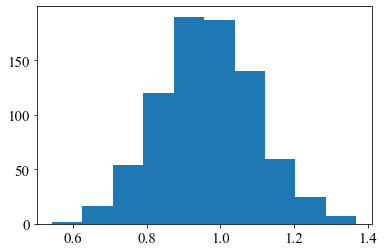

In [35]:
import numpy as np
plt.hist(np.array(MMC.get_samples()['y'][:,2]));

In [39]:
import jax
import numpyro
import numpyro.distributions as dist

def model():
    numpyro.sample("x", dist.Normal(0, 1))

# Compile the model function using JIT
compiled_model = jax.jit(model)

numpyro.set_platform("cpu")
samples = 1000
num_warmup = 500
nuts_kernel = numpyro.infer.NUTS(compiled_model)
mcmc = numpyro.infer.MCMC(nuts_kernel, num_samples=samples, num_warmup=num_warmup)
mcmc.run(jax.random.PRNGKey(0))

warmup:   0%|                                                                                              | 1/1500 [00:36<15:06:04, 36.27s/it, 1023 steps of size 1.44e+01. acc. prob=1.00]


KeyboardInterrupt: 

In [55]:
%timeit -n 10 -r 2 logL_fn_TEST({'x':jnp.ones(200),'y':jnp.linspace(0.,1.,200)},{'y':jnp.ones(Nknots)}, jnp.linspace(0.,1.,Nknots))

1 ms ± 57.3 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
